In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from pandas.plotting import parallel_coordinates
import matplotlib.cm as cm
%matplotlib inline
from sklearn.preprocessing import StandardScaler

In [4]:
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from functions import *

In [5]:
import warnings
warnings.simplefilter("ignore")

# 1. Importation et vérification des données

In [6]:
billets = pd.read_csv('billets.csv', sep=";", decimal='.')

In [7]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [8]:
billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [9]:
print(billets.isnull().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


In [10]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [11]:
billets.loc[billets.duplicated(keep=False),:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [12]:
sum(billets.duplicated())

0

# 1. Exploration des données

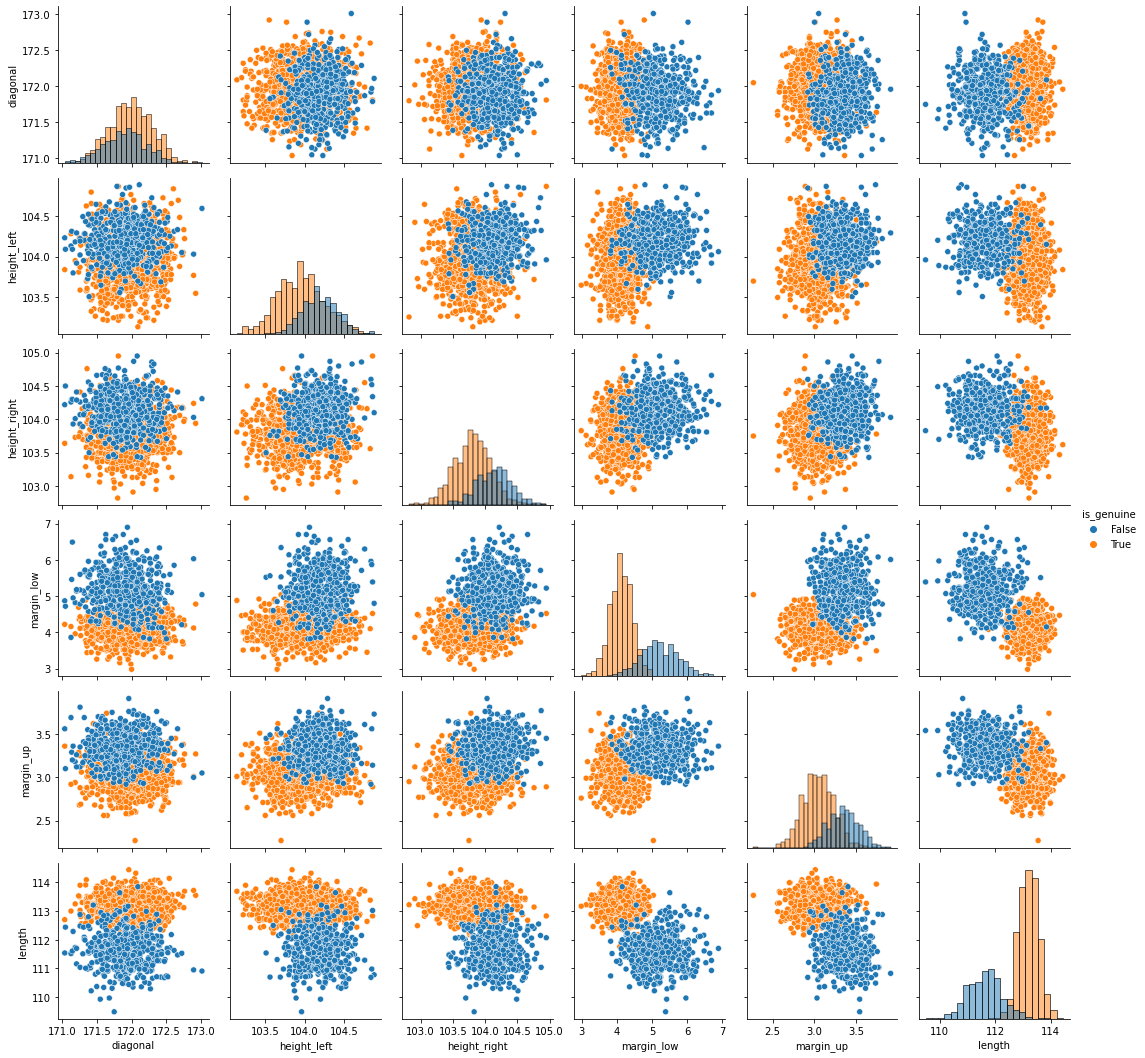

In [13]:
g = sns.PairGrid(billets, hue="is_genuine")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

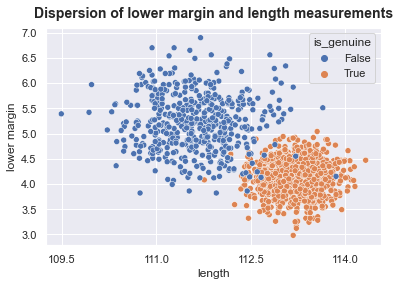

In [14]:
sns.set()

ax = sns.scatterplot(x = "length", y = "margin_low", data = billets, hue = 'is_genuine')
ax.set(xlabel = 'length', ylabel = 'lower margin')
ax.set_title('Dispersion of lower margin and length measurements', fontdict= {'fontsize': '14', 'fontweight' : 'bold'}, pad=10)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

In [15]:
# creation of a table with incomplete data
incomplete_data = billets[billets['margin_low'].isnull()]
incomplete_data = incomplete_data.reset_index(drop=True)

In [16]:
incomplete_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.94,103.89,103.45,NaN,3.25,112.79
1,True,171.93,104.07,104.18,NaN,3.14,113.08
2,True,172.07,103.80,104.38,NaN,3.02,112.93
3,True,171.45,103.66,103.80,NaN,3.62,113.27
4,True,171.83,104.14,104.06,NaN,3.02,112.36


In [17]:
complete_data = billets[billets['margin_low'].notna()]
complete_data = complete_data.reset_index(drop=True)

In [18]:
complete_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [19]:
complete_data['is_genuine'].value_counts()

True     971
False    492
Name: is_genuine, dtype: int64

In [20]:
n_true_banknotes = len(complete_data[(complete_data['is_genuine']==True)])
n_true_banknotes

971

In [21]:
n_false_banknotes = len(complete_data[(complete_data['is_genuine']==False)])
n_false_banknotes

492

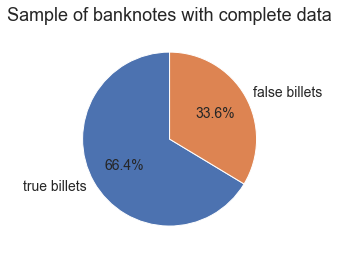

In [22]:
y = complete_data['is_genuine'].value_counts()
mylabels = ["true billets", "false billets"]
plt.title('Sample of banknotes with complete data', fontsize=18, pad=10)
plt.pie(y, labels = mylabels, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle = 90)
plt.show()

In [22]:
incomplete_data['is_genuine'].value_counts()

True     29
False     8
Name: is_genuine, dtype: int64

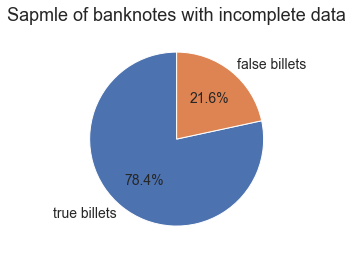

In [23]:
y = incomplete_data['is_genuine'].value_counts()
mylabels = ["true billets", "false billets"]
plt.title('Sapmle of banknotes with incomplete data', fontsize=18, pad=10)
plt.pie(y, labels = mylabels, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle = 90)
plt.show()

# 3. Imputation des données manquantes par régression linéaire simple

## 3.1. Vrais billets
### 3.1.1. Construire une régression linéaire simple

In [25]:
true_banknotes = complete_data.loc[(complete_data['is_genuine'] == True)]
true_banknotes = true_banknotes.reset_index(drop=True)

In [26]:
true_banknotes.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [27]:
regression_true_banknotes = smf.ols('margin_low ~ length', data = true_banknotes).fit()

In [28]:
print(regression_true_banknotes.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.455
Date:                Sat, 02 Jul 2022   Prob (F-statistic):              0.228
Time:                        10:42:58   Log-Likelihood:                -267.51
No. Observations:                 971   AIC:                             539.0
Df Residuals:                     969   BIC:                             548.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1885      3.256      0.058      0.9

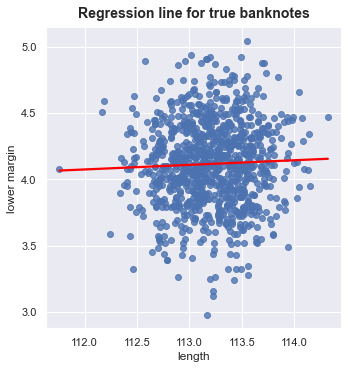

In [29]:
ax = sns.lmplot(x="length", y="margin_low", data = true_banknotes, ci=None, line_kws={'color':'red'})
ax.set(xlabel='length', ylabel='lower margin')
plt.title('Regression line for true banknotes', fontsize = 14, pad = 10, fontweight="bold")
plt.show()

### 3.1.2. Residus du modele

In [30]:
true_banknotes['residu_s'] = regression_true_banknotes.resid

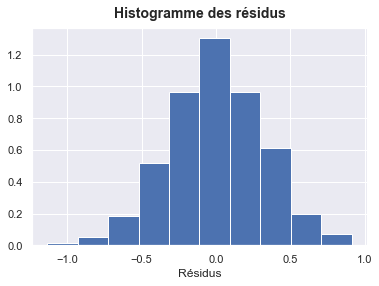

In [31]:
plt.hist(true_banknotes['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus', fontsize = 14, pad = 10, fontweight="bold")
plt.show()

**COMMENTAIRE** : la forme de l'histogramme est symétrique et suit la distribution gaussienne normale.

Text(0.5, 1.0, 'True Banknotes Model Residuals Q-Q Plot')

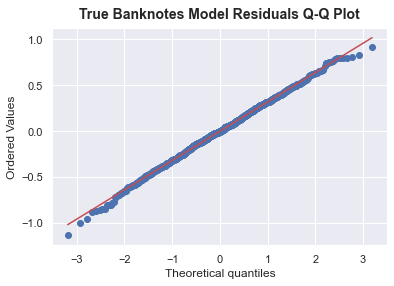

In [32]:
#Running plot & giving it a title
from scipy import stats
stats.probplot(regression_true_banknotes.resid, dist="norm", plot= plt)
plt.title("True Banknotes Model Residuals Q-Q Plot", fontsize = 14, pad = 10, fontweight="bold")

**COMMENTAIRE** : Le graphique Q-Q est utilisé pour vérifier la normalité des résidus. Dans notre cas, les données coïncident avec une ligne, confirmant la distribution normale des résidus.

### 3.1.3. Colinéarité des variables

In [33]:
true_banknotes_model = regression_true_banknotes.model.exog

In [34]:
[variance_inflation_factor(true_banknotes_model, i) for i in np.arange(1, true_banknotes_model.shape[1])]

[1.0]

**COMMENTAIRE** : le coefficient est très faible (bien en dessous du seuil de 10), donc le phénomène de colinéarité n'est pas présent.

### 3.1.4. Test d’homoscédasticité

In [35]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regression_true_banknotes.resid, true_banknotes_model)
print('p value of Breusch-Pagan test:', pval)

p value of Breusch-Pagan test: 0.3846546992961474


**COMMENTAIRE** : la valeur *p* est supérieure au seuil de 0,05, donc on maintient la typothèse conservatrice H0 sur l'homoscédasticité : la variance de la variable considérée (la marge inférieure du billet) est plutôt homogène (on a pu le voir sur le graphique ci-dessus) et va ne pas entraîner de résultats de test biaisés.

### * Linear Regression with Scikit-learn

In [36]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

In [37]:
# Creating two arrays for the feature and target
X_linear_true = true_banknotes[['length']]
y_linear_true = true_banknotes['margin_low']

In [38]:
# Create an instance of a linear regression model and fit it to the data
true_banknotes_regression = linear_model.fit(X_linear_true, y_linear_true)

In [39]:
# Obtain the coefficient of determination:
r_sq = linear_model.score(X_linear_true, y_linear_true)
print('COMMENT: the coefficient of determination is:', r_sq)

COMMENT: the coefficient of determination is: 0.0014990860493133695


**COMMENT**: the low *coefficient of determination R2* is very low and suggests that the predictive capacity of predictor is unsignificant.

In [40]:
coeff_regr_true = true_banknotes_regression.coef_
print('COMMENT: the coefficient of regression is', coeff_regr_true)

COMMENT: the coefficient of regression is [0.0346955]


**COMMENT**: the *coefficient of regression* is positive and small, suggesting the insignificant increase of the predicted value when increasing predictor.

In [41]:
tbrin = true_banknotes_regression.intercept_
print('COMMENT: the intercept of regression is', round(tbrin, 2), '(not interpretable)')

COMMENT: the intercept of regression is 0.19 (not interpretable)


In [42]:
# Running Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score
predictions_true = linear_model.predict(X_linear_true)
r2_true = r2_score(y_linear_true, predictions_true)
rmse_true = mean_squared_error(y_linear_true, predictions_true, squared=False)
print('The coefficient of correlation (r2) is: ', r2_true)
print('The root mean squared error (RMSE) is: ', rmse_true)

The coefficient of correlation (r2) is:  0.0014990860493133695
The root mean squared error (RMSE) is:  0.3187204396733733


**COMMENT**: the *Root Mean Scuared Error* is rather low (close to 0) and suggests a good quality of the linear regression model.

In [43]:
residual_true = (y_linear_true - predictions_true)

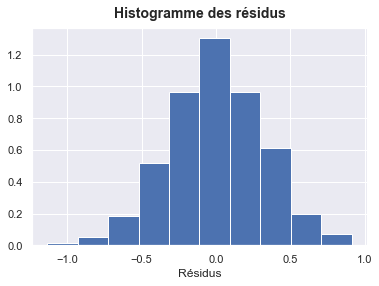

In [44]:
plt.hist(residual_true, density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus', fontsize = 14, pad = 10, fontweight="bold")
plt.show()

**COMMENT**: the alternative way of residuals calculation gave the same results.

### 3.1.5. Predicting missing data on true banknotes

In [45]:
true_banknotes_to_predict = incomplete_data.loc[(incomplete_data['is_genuine'] == True)]
true_banknotes_to_predict = true_banknotes_to_predict.reset_index(drop=True)

In [46]:
predicting_true_banknotes = regression_true_banknotes.predict(true_banknotes_to_predict)

In [47]:
print(predicting_true_banknotes)

0     4.101766
1     4.111827
2     4.106623
3     4.118419
4     4.086846
5     4.116685
6     4.119113
7     4.121542
8     4.107317
9     4.107317
10    4.108011
11    4.143400
12    4.131604
13    4.103500
14    4.101766
15    4.118419
16    4.096908
17    4.088581
18    4.111480
19    4.123277
20    4.159013
21    4.121195
22    4.130563
23    4.118419
24    4.137502
25    4.132645
26    4.101419
27    4.097949
28    4.121889
dtype: float64


In [48]:
true_banknotes_to_predict['margin_low'] = predicting_true_banknotes

In [49]:
true_banknotes_to_predict.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.94,103.89,103.45,4.101766,3.25,112.79
1,True,171.93,104.07,104.18,4.111827,3.14,113.08
2,True,172.07,103.80,104.38,4.106623,3.02,112.93
3,True,171.45,103.66,103.80,4.118419,3.62,113.27
4,True,171.83,104.14,104.06,4.086846,3.02,112.36


## 3.2. Faux billets
### 3.2.1. Building simple linear regression

In [50]:
false_banknotes = complete_data.loc[(complete_data['is_genuine'] == False)]
false_banknotes = false_banknotes.reset_index(drop=True)

In [51]:
false_banknotes.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,False,172.28,103.95,103.91,4.78,3.31,111.40
1,False,171.92,103.86,104.30,4.96,3.13,111.29
2,False,171.59,104.14,104.38,4.97,3.47,111.22
3,False,172.02,104.33,104.33,5.19,3.21,111.99
4,False,172.55,104.25,104.23,5.60,3.13,111.72


In [52]:
regression_false_banknotes = smf.ols('margin_low ~ length', data = false_banknotes).fit()

In [53]:
print(regression_false_banknotes.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4591
Date:                Sat, 02 Jul 2022   Prob (F-statistic):              0.498
Time:                        10:49:49   Log-Likelihood:                -406.40
No. Observations:                 492   AIC:                             816.8
Df Residuals:                     490   BIC:                             825.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2881      4.534      1.828      0.0

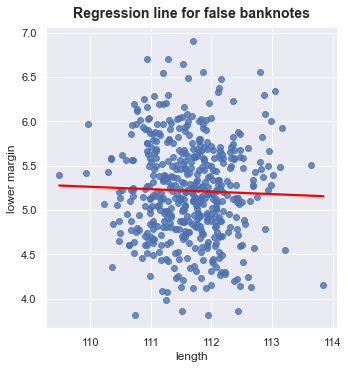

In [54]:
ax = sns.lmplot(x="length", y="margin_low", data = false_banknotes, ci=None, line_kws={'color':'red'})
ax.set(xlabel='length', ylabel='lower margin')
plt.title('Regression line for false banknotes', fontsize = 14, pad = 10, fontweight="bold")
plt.show()

### 3.2.2. Résidus du modèle

In [55]:
false_banknotes['residu_s'] = regression_false_banknotes.resid

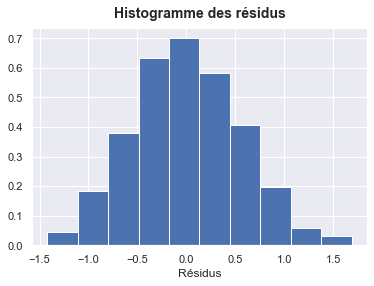

In [56]:
plt.hist(false_banknotes['residu_s'], density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus', fontsize = 14, pad = 10, fontweight="bold")
plt.show()

**COMMENT**: the shape of histogram is symmetric and follows the normal Gaussian distribution.

Text(0.5, 1.0, 'False Banknotes Model Residuals Q-Q Plot')

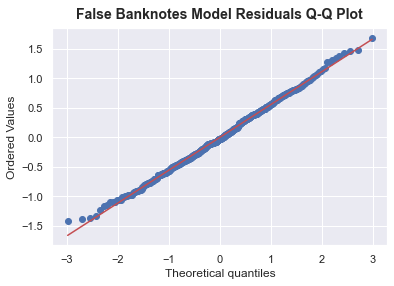

In [57]:
#Running plot & giving it a title
from scipy import stats
stats.probplot(regression_false_banknotes.resid, dist="norm", plot= plt)
plt.title("False Banknotes Model Residuals Q-Q Plot", fontsize = 14, pad = 10, fontweight="bold")

### 3.2.3. Colinéarité des variables

In [58]:
false_banknotes_model = regression_false_banknotes.model.exog

In [59]:
[variance_inflation_factor(false_banknotes_model, i) for i in np.arange(1, false_banknotes_model.shape[1])]

[1.0]

### 3.2.4. Test d’homoscédasticité

In [60]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regression_false_banknotes.resid, false_banknotes_model)
print('p value of Breusch-Pagan test:', pval)

p value of Breusch-Pagan test: 0.5341320765973878


**COMMENT**: the *p* value is above the 0.05 threshold, therefore we maintain the conservative H0 typothesis on homoscedasticity: the variance of the variable under consideration (the lower margin of banknote) is homogene.

### * Linear Regression with Scikit-learn

In [61]:
X_linear_false = false_banknotes[['length']]
y_linear_false = false_banknotes['margin_low']
false_banknotes_regression = linear_model.fit(X_linear_false, y_linear_false)

In [62]:
# The coefficient of determination:
r_sq_false = linear_model.score(X_linear_false, y_linear_false)
print('COMMENT: the coefficient of determination is:', r_sq_false)

COMMENT: the coefficient of determination is: 0.0009359649636281331


**COMMENT**: the low *coefficient of determination R2* is extremely low and suggests that the predictive capacity of predictor is practically unsignificant.

In [63]:
# The coefficient of regression:
coeff_regr_false = false_banknotes_regression.coef_
print('COMMENT: the coefficient of regression is', coeff_regr_false)

COMMENT: the coefficient of regression is [-0.0275204]


**COMMENT**: the *coefficient of regression* is negative and rather close to 0; it means that the predicted value (y) shows a weak decrease with increase of predictor (x).

In [64]:
# the intercept of regression for false banknotes:
fbrin = false_banknotes_regression.intercept_
print('COMMENT: the intercept of regression is', round(tbrin, 2), '(not interpretable)')

COMMENT: the intercept of regression is 0.19 (not interpretable)


In [65]:
predictions_false = linear_model.predict(X_linear_false)
r2_false = r2_score(y_linear_false, predictions_false)
rmse_false = mean_squared_error(y_linear_false, predictions_false, squared=False)
print('The coefficient of correlation (r2) is: ', r2_false)
print('The root mean squared error (RMSE) is: ', rmse_false)

The coefficient of correlation (r2) is:  0.0009359649636281331
The root mean squared error (RMSE) is:  0.5527096271845046


**COMMENT**: the *Root Mean Scuared Error* is rather low and suggests a good quality of the linear regression model.

In [66]:
residual_false = (y_linear_false - predictions_false)

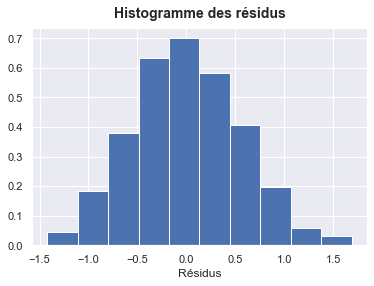

In [67]:
plt.hist(residual_false, density=True)
plt.xlabel('Résidus')
plt.title('Histogramme des résidus', fontsize = 14, pad = 10, fontweight="bold")
plt.show()

### 3.2.5. Predicting missing data on false banknotes

In [68]:
false_banknotes_to_predict = incomplete_data.loc[(incomplete_data['is_genuine'] == False)]
false_banknotes_to_predict = false_banknotes_to_predict.reset_index(drop=True)

In [69]:
predicting_false_banknotes = regression_false_banknotes.predict(false_banknotes_to_predict)

In [70]:
predicting_false_banknotes

0    5.209388
1    5.195078
2    5.225350
3    5.227552
4    5.197830
5    5.252320
6    5.220396
7    5.219846
dtype: float64

In [71]:
false_banknotes_to_predict['margin_low'] = predicting_false_banknotes

In [72]:
false_banknotes_to_predict.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,False,171.57,104.27,104.44,5.209388,3.21,111.87
1,False,171.40,104.38,104.19,5.195078,3.17,112.39
2,False,171.59,104.05,103.94,5.225350,3.02,111.29
3,False,172.17,104.49,103.76,5.227552,2.93,111.21
4,False,172.08,104.15,104.17,5.197830,3.40,112.29


## 3.3. Building the new dataframe filled with predicted data

In [73]:
completed_data = complete_data.append(true_banknotes_to_predict, ignore_index=True)

In [74]:
completed_data = completed_data.append(false_banknotes_to_predict, ignore_index=True)

In [75]:
completed_data.shape

(1500, 7)

In [76]:
completed_data.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,172.17,104.49,103.76,5.227552,2.93,111.21
1496,False,172.08,104.15,104.17,5.197830,3.40,112.29
1497,False,171.72,104.46,104.12,5.252320,3.61,110.31
1498,False,172.66,104.33,104.41,5.220396,3.56,111.47
1499,False,171.90,104.28,104.29,5.219846,3.24,111.49


In [77]:
test_data = true_banknotes_to_predict.append(false_banknotes_to_predict, ignore_index=True)

In [78]:
test_data.shape

(37, 7)

In [79]:
test_data.sample()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
35,False,172.66,104.33,104.41,5.220396,3.56,111.47


### 3.4. Corrélations des variables

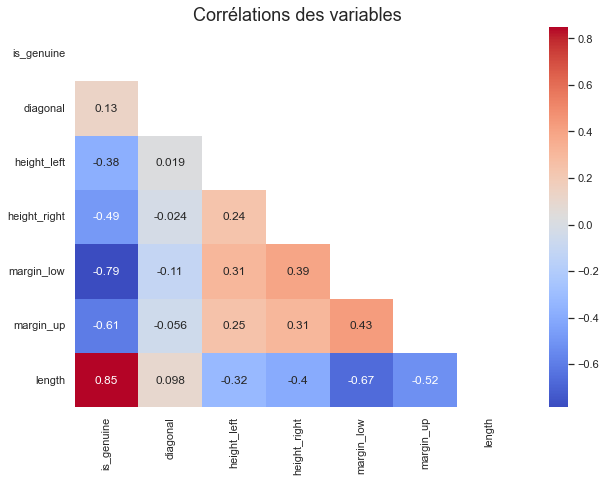

In [80]:
corr = completed_data.corr()
sns.set_style(style='white')

matrix = np.triu(corr)

sns.heatmap(corr, annot=True, mask=matrix, cmap="coolwarm",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values).set_title('Corrélations des variables',fontsize=18)
fig = plt.gcf()
fig.set_size_inches(10, 7)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True


plt.show()

# 4. Algorithme K-means
## 4.1. Data preprocessing

In [81]:
kmeans_data = completed_data.drop('is_genuine', 1)

In [82]:
# standartization of data
scaler = StandardScaler()

completed_data_scaled = scaler.fit_transform(kmeans_data)

In [83]:
completed_data_scaled

array([[-0.48653957,  2.77412327,  3.16324041,  0.0565414 , -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08060921, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.1254027 , -0.91256208,
         0.55190114],
       ...,
       [-0.78153123,  1.43794766,  0.61346228,  1.16688568,  1.97866106,
        -2.71480344],
       [ 2.29949275,  1.00369058,  1.50434862,  1.11848299,  1.76289814,
        -1.38519737],
       [-0.19154792,  0.83666863,  1.135706  ,  1.11764846,  0.38201544,
        -1.36227312]])

## 4.2. Number of clusters
### 4.2.1. Silhouette score

In [84]:
#silhouette score
range_n_clusters = list (range(2,5))

Pour n_clusters = 2 le silhouette_score moyen est : 0.3399535726288869
Pour n_clusters = 3 le silhouette_score moyen est : 0.22628412510872598
Pour n_clusters = 4 le silhouette_score moyen est : 0.047930534601247105


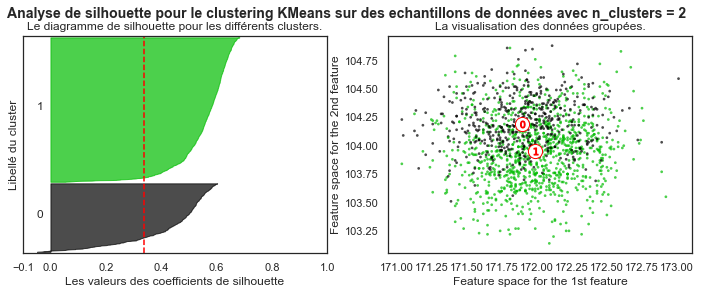

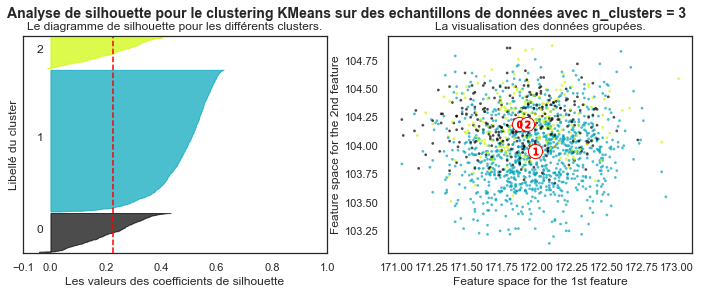

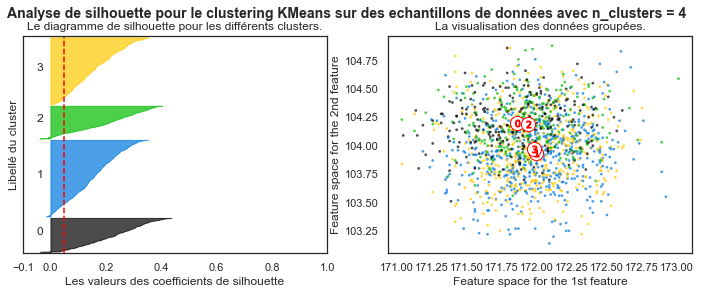

In [85]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(completed_data_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(kmeans_data)

    silhouette_avg = silhouette_score(completed_data_scaled, cluster_labels)
    print(
        "Pour n_clusters =",
        n_clusters,
        "le silhouette_score moyen est :",
        silhouette_avg,
    )
    
    sample_silhouette_values = silhouette_samples(kmeans_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Le diagramme de silhouette pour les différents clusters.")
    ax1.set_xlabel("Les valeurs des coefficients de silhouette")
    ax1.set_ylabel("Libellé du cluster")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        kmeans_data.iloc[:, 0], kmeans_data.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="red",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="red")

    ax2.set_title("La visualisation des données groupées.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Analyse de silhouette pour le clustering KMeans sur des echantillons de données avec n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### 4.2.2. Metode du coude

In [86]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(completed_data_scaled)
    Sum_of_squared_distances.append(km.inertia_)

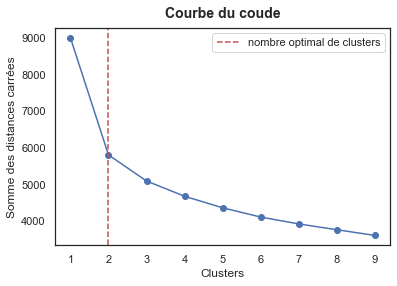

In [87]:
plt.plot(K, Sum_of_squared_distances, 'bo-')
plt.xlabel('Clusters')
plt.ylabel('Somme des distances carrées')
plt.title('Courbe du coude', fontsize = 14, pad = 10, fontweight="bold")
plt.axvline(x = 2, color = 'r', linestyle="--", label = 'nombre optimal de clusters')
plt.legend()
plt.show()

**COMMENT**: according to the elbow plot, there are two well-defined clusters in the analysed data

## 4.3. K-means clustering

### 4.3.1. K-means algorithm

In [88]:
kmeans = KMeans(init = "random", n_clusters = 2, n_init = 10, max_iter = 300, random_state = 42)

In [89]:
kmeans.fit(completed_data_scaled)

KMeans(init='random', n_clusters=2, random_state=42)

In [90]:
# HERE WE ESTABLISH CLUSTERS
clusters =  kmeans.predict(completed_data_scaled)

In [91]:
billets2 = completed_data.copy()

In [92]:
billets2['cluster'] = clusters

In [93]:
billets2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0
1,True,171.46,103.36,103.66,3.77,2.99,113.09,1
2,True,172.69,104.48,103.50,4.40,2.94,113.16,1
3,True,171.36,103.91,103.94,3.62,3.01,113.51,1
4,True,171.73,104.28,103.46,4.04,3.48,112.54,1


In [94]:
billets2.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
1495,False,172.17,104.49,103.76,5.227552,2.93,111.21,0
1496,False,172.08,104.15,104.17,5.197830,3.40,112.29,0
1497,False,171.72,104.46,104.12,5.252320,3.61,110.31,0
1498,False,172.66,104.33,104.41,5.220396,3.56,111.47,0
1499,False,171.90,104.28,104.29,5.219846,3.24,111.49,0


In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(completed_data_scaled)

data_reduced_dimensions = pca.transform(completed_data_scaled)

In [96]:
data_reduced_dimensions

array([[ 1.64634675,  0.74745753],
       [-2.01968616, -2.20685695],
       [-0.96886893,  2.61969589],
       ...,
       [ 3.67681975, -0.45393312],
       [ 2.80192514,  2.47892066],
       [ 2.19318808,  0.05043037]])

In [97]:
# Convert to a data frame
data_reduced_dimensions_df = pd.DataFrame(data_reduced_dimensions, index=completed_data.index, columns=['PC1','PC2'])
data_reduced_dimensions_df['cluster'] = clusters
data_reduced_dimensions_df.head()

,PC1,PC2,cluster
0,1.646347,0.747458,0
1,-2.019686,-2.206857,1
2,-0.968869,2.619696,1
3,-1.376050,-1.817894,1
4,0.150584,-0.566797,1


In [98]:
# HERE WE FIND CLUSTER CENTRES
cluster_centres = pca.transform(kmeans.cluster_centers_)

In [99]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['cornflowerblue', 'darkorange'])

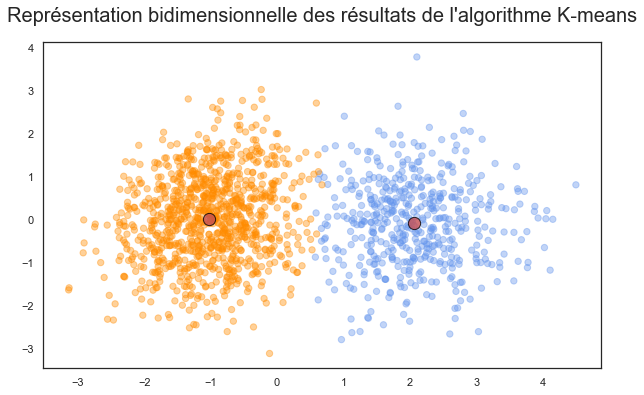

In [100]:
fig = plt.figure(figsize=(10,6))
plt.scatter(data_reduced_dimensions_df['PC1'], data_reduced_dimensions_df['PC2'],
                     c=clusters, s=40, cmap=cmap, alpha=0.4)
plt.scatter(cluster_centres[:, 0], cluster_centres[:, 1],
            marker='o',s=150, linewidths=1,
            color='r', edgecolor = 'black', zorder=10, alpha=0.8)
plt.title("Représentation bidimensionnelle des résultats de l'algorithme K-means", fontsize = 20, pad = 20)
plt.show()

**COMMENT** : cluster 1, true banknotes; cluster 0, false banknotes

### 4.3.2. Error rates

In [101]:
kmeans_verification = data_reduced_dimensions_df.copy()

In [102]:
kmeans_verification['is_genuine'] = completed_data['is_genuine']

In [103]:
kmeans_verification.head()

,PC1,PC2,cluster,is_genuine
0,1.646347,0.747458,0,True
1,-2.019686,-2.206857,1,True
2,-0.968869,2.619696,1,True
3,-1.376050,-1.817894,1,True
4,0.150584,-0.566797,1,True


In [104]:
correct_true = len(kmeans_verification[(kmeans_verification['cluster']==1) & (kmeans_verification['is_genuine']==True)])
correct_true

990

In [105]:
correct_false = len(kmeans_verification[(kmeans_verification['cluster']==0) & (kmeans_verification['is_genuine']==False)])
correct_false

486

In [106]:
wrong_true = len(kmeans_verification[(kmeans_verification['cluster']==0) & (kmeans_verification['is_genuine']==True)])
wrong_true

10

In [107]:
wrong_false = len(kmeans_verification[(kmeans_verification['cluster']==1) & (kmeans_verification['is_genuine']==False)])
wrong_false

14

In [108]:
total_sample = len(kmeans_verification)
total_sample

1500

In [109]:
print('The number of true banknotes reported as false attains', round(wrong_true/total_sample*100, 2), '% of the total sample (was 0.62%).')

The number of true banknotes reported as false attains 0.67 % of the total sample (was 0.62%).


In [110]:
print('The number of true banknotes reported as false attains', round(wrong_true/n_true_banknotes*100, 2), '% of the true banknotes sample (was 0.93%).')

The number of true banknotes reported as false attains 1.03 % of the true banknotes sample (was 0.93%).


In [111]:
print('The number of false banknotes reported as true attains', round(wrong_false/total_sample*100, 2), '% of the total sample (was 0.89%).')

The number of false banknotes reported as true attains 0.93 % of the total sample (was 0.89%).


In [112]:
print('The number of false banknotes reported as true attains', round(wrong_false/n_false_banknotes*100, 2), '% of the false banknotes sample (was 2.64%).')

The number of false banknotes reported as true attains 2.85 % of the false banknotes sample (was 2.64%).


**Positive predictive value** - the ratio of the number of true positives to the sum of the numbers of true and false positives:

In [113]:
positive_predictive_value = correct_true / (correct_true + wrong_true)
positive_predictive_value

0.99

**Negative predictive value** - the ratio of the number of true negatives to the sum of the numbers of true and false negatives:

In [114]:
negative_predictive_value = correct_false / (correct_false + wrong_false)
negative_predictive_value

0.972

**Sensitivity** (= recall, = true positive rate) - the ratio of the number of true positives to the number of actual positives:

In [115]:
sensitivity = round(correct_true / (correct_true + wrong_false), 3)
sensitivity

0.986

 **Specificity** (true negative rate) - the ratio of the number of true negatives to the number of actual negatives:

In [116]:
specificity = round(correct_false / (correct_false + wrong_true), 3)
specificity

0.98

## 4.4. Prédiction réalisée avec K-means clustering

In [117]:
def predict_banknote(banknotes_to_test, centroids):
    centroids, banknotes_to_test = np.array(centroids), np.array(banknotes_to_test)
    distances = []
    for unit in banknotes_to_test:
        for center in centroids:
            distances.append(np.sum((unit - center) ** 2))                
    distances = np.reshape(distances, banknotes_to_test.shape)
    closest_centroid = [np.argmin(dist) for dist in distances]
    for cluster_number in closest_centroid:
        if cluster_number == 1:
            print(cluster_number, ': true banknote')
        else:
            print(cluster_number, ': false banknote')

In [118]:
# data to predict
billets_kmeans_prediction = pd.read_csv('billets_production.csv')
billets_kmeans_prediction.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [119]:
billets_kmeans_set_index = billets_kmeans_prediction.set_index('id')

In [120]:
# standartisation
billets_kmeans_index_scaled = scaler.fit_transform(billets_kmeans_set_index)

In [121]:
# transformation
pca_pred = PCA(n_components=2)
pca_pred.fit(billets_kmeans_index_scaled)
billets_kmeans_reduced = pca_pred.transform(billets_kmeans_index_scaled)

In [122]:
# Convert to a data frame
billets_kmeans_reduced_df = pd.DataFrame(billets_kmeans_reduced, columns=['PC1','PC2'])
# data_reduced_dimensions_df['cluster'] = clusters
billets_kmeans_reduced_df.head()

,PC1,PC2
0,-1.417116,-1.099578
1,0.147333,-1.339851
2,1.047663,-1.529149
3,2.412602,1.940940
4,-2.190483,2.027638


In [123]:
banknotes_to_test = billets_kmeans_reduced_df
centroids = cluster_centres

In [124]:
kmeans_result = predict_banknote(banknotes_to_test, centroids)
kmeans_result

1 : true banknote
1 : true banknote
0 : false banknote
0 : false banknote
1 : true banknote


# 5. Analyse en composantes principales

## 5.1. Prétraitement des données

In [125]:
complete_data_pca = scaler.fit_transform(kmeans_data)

In [126]:
complete_data_pca_df = pd.DataFrame(complete_data_pca, columns=['PC1','PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

In [127]:
complete_data_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.486540,2.774123,3.163240,0.056541,-1.128325,0.173651
1,-1.633729,-2.236535,-0.799668,-1.080609,-0.696799,0.471666
2,2.397823,1.504756,-1.291191,-0.125403,-0.912562,0.551901
3,-1.961498,-0.399294,0.060498,-1.308039,-0.610494,0.953075
4,-0.748754,0.836669,-1.414072,-0.671235,1.417677,-0.158750


In [128]:
pca_plot = complete_data_pca_df
pca_plot['cluster'] = clusters

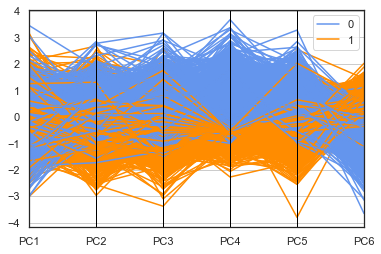

In [129]:
colors = ['cornflowerblue', 'darkorange']

parallel_coordinates(pca_plot, 'cluster', color = colors)
plt.show()

## 5.2. Effectuer ACP

In [130]:
# Create the PCA model
pca_2 = PCA(n_components=5)
# Fit the model with the standardised data
pca_2.fit_transform(complete_data_pca)

array([[ 1.64634675,  0.74745753,  2.40043665,  3.18251634,  0.29214664],
       [-2.01968616, -2.20685695, -1.00213486,  0.07371998,  0.03688155],
       [-0.96886893,  2.61969589,  1.19813366, -0.92761751, -0.83503048],
       ...,
       [ 3.67681975, -0.45393312,  0.32762754, -0.91849686,  0.30426343],
       [ 2.80192514,  2.47892066, -0.82560431, -0.10628794,  0.38334775],
       [ 2.19318808,  0.05043037,  0.18079552,  0.45142595, -0.40472674]])

In [131]:
pca_individuals = pca_2.fit_transform(complete_data_pca)

In [132]:
pca_individuals_df = pd.DataFrame(pca_individuals, columns=['PC1','PC2', 'PC3', 'PC4', 'PC5'])

In [133]:
pca_individuals_df['cluster'] = clusters

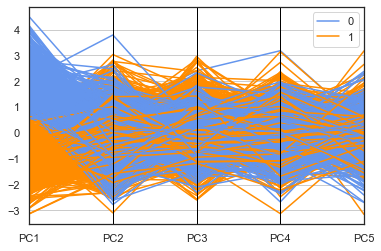

In [134]:
parallel_coordinates(pca_individuals_df, 'cluster', color = colors)
plt.show()

## 5.3. Définition du nombre de composants principaux

In [139]:
explained_variances = pca_2.explained_variance_ratio_

In [140]:
print(explained_variances)

[0.43219426 0.16956726 0.13021585 0.11826763 0.09645713]


In [141]:
cum_sum_eigenvalues = pca_2.explained_variance_ratio_.cumsum()
print(cum_sum_eigenvalues)

[0.43219426 0.60176152 0.73197737 0.85024501 0.94670213]


### 5.3.1. Scree plot

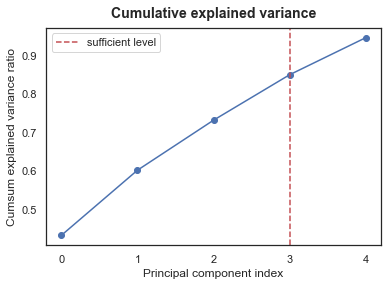

In [142]:
sns.set_style(style='white')
plt.plot(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 'bo-')
plt.title("Cumulative explained variance", fontsize = 14, pad = 10, fontweight="bold")
plt.xticks(np.arange(0, len(cum_sum_eigenvalues), step=1))
plt.axvline(x = 3, color = 'r', linestyle="--", label = 'sufficient level')
plt.legend()
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Principal component index")
plt.show()

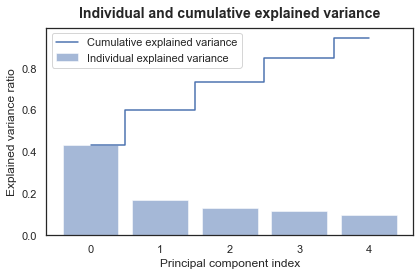

In [143]:
sns.set_style(style='white')
plt.bar(range(0,len(explained_variances)), explained_variances, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.title("Individual and cumulative explained variance", fontsize = 14, pad = 10, fontweight="bold")
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 5.3.2. Eigenvalues

In [144]:
# eigenvalues
n = kmeans_data.shape[0]
eigenvalue = (n-1)/n*pca_2.explained_variance_ 
print(eigenvalue)

[2.59316554 1.01740358 0.78129512 0.70960579 0.57874277]


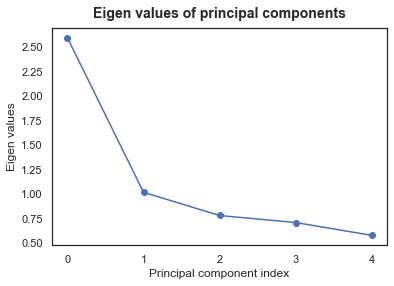

In [145]:
# skree plot
sns.set_style(style='white')
plt.plot(range(0, len(cum_sum_eigenvalues)), eigenvalue, 'bo-')
plt.title("Eigen values of principal components", fontsize = 14, pad = 10, fontweight="bold")
plt.xticks(np.arange(0, len(cum_sum_eigenvalues), step=1))
plt.ylabel("Eigen values") 
plt.xlabel("Principal component index") 
plt.show()

## 5.4. Représentation des individus dans les plans factoriels

In [146]:
pca_individuals_df.head()

,PC1,PC2,PC3,PC4,PC5,cluster
0,1.646347,0.747458,2.400437,3.182516,0.292147,0
1,-2.019686,-2.206857,-1.002135,0.073720,0.036882,1
2,-0.968869,2.619696,1.198134,-0.927618,-0.835030,1
3,-1.376050,-1.817894,0.649535,0.832228,0.799672,1
4,0.150584,-0.566797,0.852128,-1.782094,1.188644,1


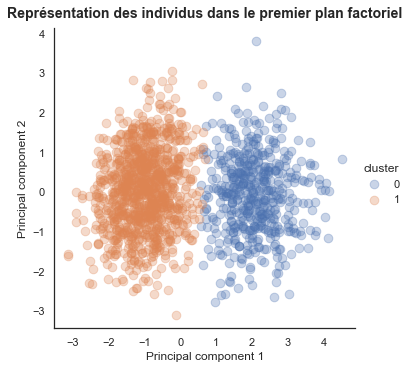

In [200]:
sns.set_style(style='white')
 
sns.lmplot(
    x = 'PC1', 
    y = 'PC2', 
    data = pca_individuals_df,
    hue = 'cluster',
    fit_reg = False, scatter_kws={"alpha":0.3,"s":75} ,
    legend = True
    )
plt.title("Représentation des individus dans le premier plan factoriel", fontsize = 14, pad = 10, fontweight="bold")
plt.xlabel('Principal component 1', fontsize=12)
plt.ylabel('Principal component 2', fontsize=12)
plt.show()

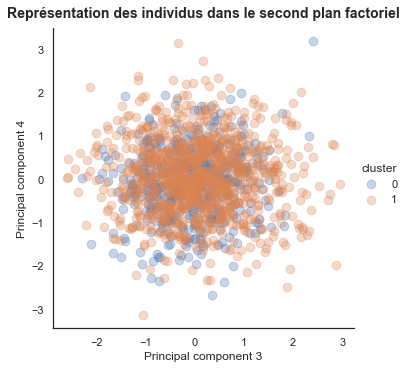

In [201]:
sns.set_style(style='white')
 
sns.lmplot(
    x = 'PC3', 
    y = 'PC4', 
    data = pca_individuals_df, 
    hue = 'cluster', 
    fit_reg = False, scatter_kws={"alpha":0.3,"s":75} ,
    legend = True
    )
plt.title("Représentation des individus dans le second plan factoriel", fontsize = 14, pad = 10, fontweight="bold")
plt.xlabel('Principal component 3', fontsize=12)
plt.ylabel('Principal component 4', fontsize=12)
plt.show()

## 5.5. Cercle des corrélations

In [153]:
print(pca_2.components_)

[[-0.08475831  0.33119279  0.39364583  0.50677236  0.43952229 -0.52742039]
 [ 0.94132926  0.30726321  0.10854956 -0.07286949 -0.00474866  0.04871367]
 [-0.28733449  0.8848341  -0.16431215 -0.10783995 -0.27108141  0.14964767]
 [-0.10269295 -0.04863418  0.86747727 -0.09253382 -0.44134046  0.1767149 ]
 [-0.1164058   0.10277863  0.23178126 -0.56940326  0.7117473   0.30225719]]


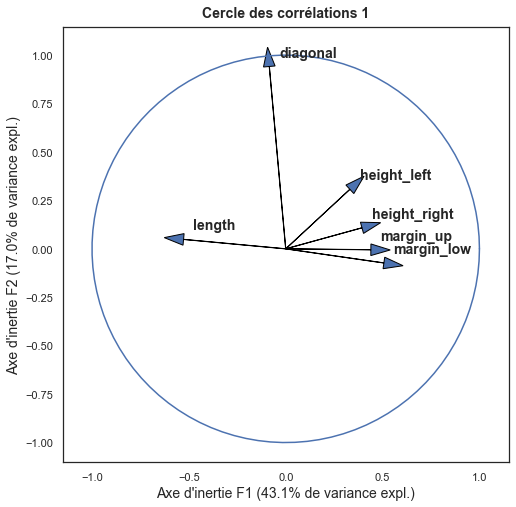

In [202]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for j in range(0, pca.components_.shape[1]):
    ax.arrow(0, 0,  # Start the arrow at the origin
             pca_2.components_[0, j], #0 for PC1
             pca_2.components_[1, j], #1 for PC2 
             head_width=0.06,
             head_length=0.1,
             edgecolor = 'black')

    plt.text(pca_2.components_[0, j] + 0.05,
             pca_2.components_[1, j] + 0.05,
            kmeans_data.columns.values[j], fontsize=14, fontweight="bold")

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis('equal')
plt.xlabel("Axe d'inertie F1 (43.1% de variance expl.)", fontsize=14)
plt.ylabel("Axe d'inertie F2 (17.0% de variance expl.)", fontsize=14)
ax.set_title('Cercle des corrélations 1', fontsize = 14, pad = 10, fontweight="bold")
plt.show()

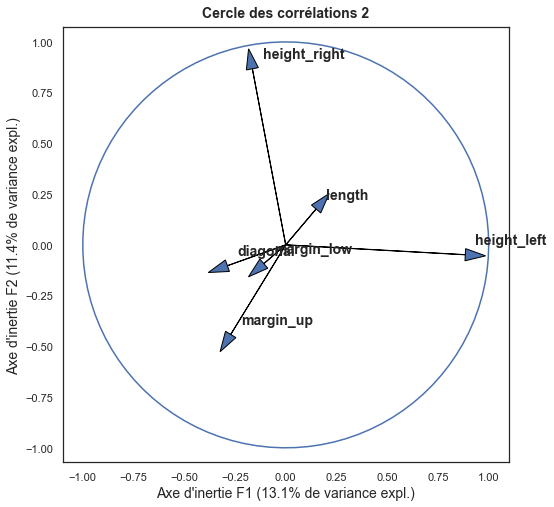

In [203]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for j in range(0, pca_2.components_.shape[1]):
    ax.arrow(0, 0,
             pca_2.components_[2, j], #0 for PC3
             pca_2.components_[3, j], #1 for PC4 
             head_width=0.06,
             head_length=0.1,
             edgecolor = 'black')

    plt.text(pca_2.components_[2, j] + 0.05,
             pca_2.components_[3, j] + 0.05,
            kmeans_data.columns.values[j], fontsize=14, fontweight="bold")

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis('equal')
plt.xlabel("Axe d'inertie F1 (13.1% de variance expl.)", fontsize=14)
plt.ylabel("Axe d'inertie F2 (11.4% de variance expl.)", fontsize=14)
ax.set_title('Cercle des corrélations 2', fontsize = 14, pad = 10, fontweight="bold")
plt.show()

## 5.6. Carte factorielle et cercle de corrélation combinés

In [157]:
normalisation_step_1 = pca_individuals_df.max()
normalisation_step_2 = normalisation_step_1.max()
normalized_df = pca_individuals_df / normalisation_step_2

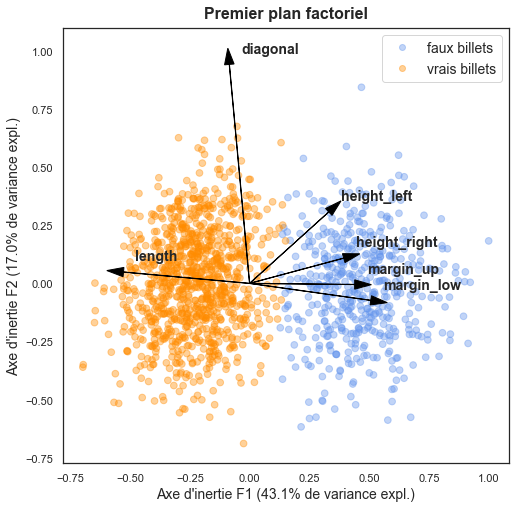

In [204]:
(fig, ax) = plt.subplots(figsize=(8, 8))
cluster_names = ['faux billets', 'vrais billets']
scatter = plt.scatter(normalized_df.PC1, normalized_df.PC2, c=normalized_df['cluster'], s=45, cmap= cmap, alpha=0.4)

for j in range(0, pca_2.components_.shape[1]):
    ax.arrow(0, 0,  # Start the arrow at the origin
             pca_2.components_[0, j], #0 for PC1
             pca_2.components_[1, j], #1 for PC2 
             head_width=0.04,
             head_length=0.07,
             color = 'black')
    
    plt.text(pca_2.components_[0, j] + 0.05,
             pca_2.components_[1, j] + 0.05,
            kmeans_data.columns.values[j], fontsize=14, fontweight="bold")

ax.legend(handles= scatter.legend_elements()[0], labels=cluster_names, fontsize=14)
plt.title("Premier plan factoriel", fontsize = 16, pad = 10, fontweight="bold")
plt.xlabel("Axe d'inertie F1 (43.1% de variance expl.)", fontsize=14)
plt.ylabel("Axe d'inertie F2 (17.0% de variance expl.)", fontsize=14)
fig.show()


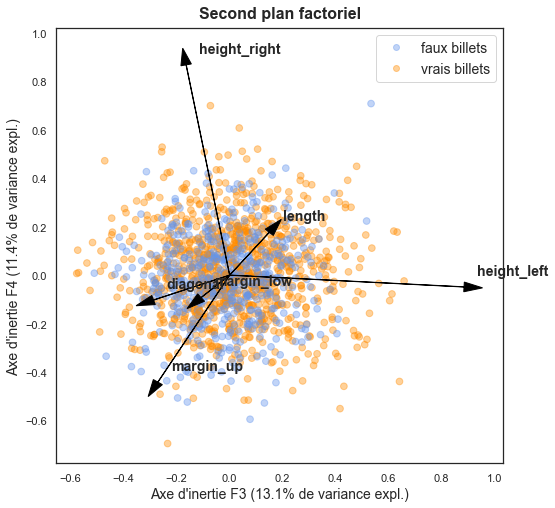

In [205]:
(fig, ax) = plt.subplots(figsize=(8, 8))
cluster_names = ['faux billets', 'vrais billets']
scatter = plt.scatter(normalized_df.PC3, normalized_df.PC4, c=normalized_df['cluster'], s=45, cmap= cmap, alpha=0.4)

for j in range(0, pca_2.components_.shape[1]):
    ax.arrow(0, 0,  # Start the arrow at the origin
             pca_2.components_[2, j], #0 for PC1
             pca_2.components_[3, j], #1 for PC2 
             head_width=0.04,
             head_length=0.07,
             color = 'black')
    
    plt.text(pca_2.components_[2, j] + 0.05,
             pca_2.components_[3, j] + 0.05,
            kmeans_data.columns.values[j], fontsize=14, fontweight="bold")

ax.legend(handles= scatter.legend_elements()[0], labels=cluster_names, fontsize=14)
plt.title("Second plan factoriel", fontsize = 16, pad = 10, fontweight="bold")
plt.xlabel("Axe d'inertie F3 (13.1% de variance expl.)", fontsize=14)
plt.ylabel("Axe d'inertie F4 (11.4% de variance expl.)", fontsize=14)
fig.show()

# 6. Régression logistique

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics

## 6.1. Fractionnement des données en ensembles d'apprentissage et de test

In [164]:
completed_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [165]:
completed_data.shape

(1500, 7)

Text(0.5, 1.0, 'Regression logistique')

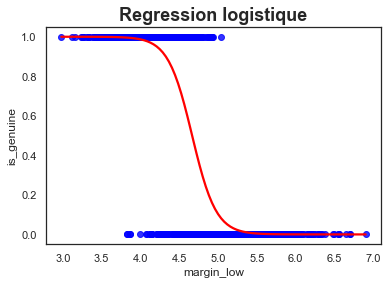

In [206]:
sns.regplot(x="margin_low", y="is_genuine", data = completed_data, logistic=True, ci=None, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}).set_title('Regression logistique', fontsize = 18, weight='bold')

In [167]:
all_features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
x = completed_data[all_features]

In [168]:
y = completed_data['is_genuine']

In [169]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## 6.2. Création d'un modèle
### 6.2.1. Entraînement de modele

In [170]:
model = LogisticRegression(solver='liblinear', C=1, multi_class='ovr', random_state=0)
model.fit(x_train, y_train)

LogisticRegression(C=1, multi_class='ovr', random_state=0, solver='liblinear')

**COMMENTAIRE**: le changement de force de régularisation de 1 à 10 n'a pas amélioré la qualité du modèle.

### 6.2.2. Test de modele

In [171]:
# running the model using the test data
y_pred = model.predict(x_test)

In [172]:
print(y_pred)

[ True  True False  True False False  True  True  True False False False
 False  True  True  True False False  True False  True  True  True  True
 False  True False  True  True False False  True False  True False False
  True  True  True  True False False False  True  True  True False  True
  True False  True False  True False  True False  True  True False False
  True  True False  True  True  True  True False  True False  True  True
  True False  True  True  True  True  True False False  True  True  True
  True  True False  True  True  True  True  True  True  True False False
  True  True  True  True False False  True  True False  True  True  True
  True False  True  True  True  True False  True  True False  True  True
  True  True  True  True  True False  True  True False  True  True  True
  True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True False  True  True False  True  True  True  True
 False  True  True  True False  True  True False  T

### 6.2.3. Évaluation des performances du modèle

In [173]:
# rate of true prediction
model.score(x_train, y_train)

0.9916666666666667

In [174]:
# Evaluate the model on the test data
prediction_banknotes = model.predict(x_test)
print('Logistic regression performance:', accuracy_score(y_test, prediction_banknotes))

Logistic regression performance: 0.9866666666666667


In [175]:
model.score(x_test, y_test)

0.9866666666666667

In [176]:
model.coef_

array([[ 0.0915794 , -1.71030164, -2.14988235, -3.44090654, -3.23274124,
         3.66421542]])

In [177]:
y_pred = model.predict(x_test)

In [178]:
# confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 99,   3],
       [  1, 197]], dtype=int64)

**COMMENTAIRE** : correctes fausse billets - 99 ; incorrectes fausse billets - 1; incorrectes vrai billets - 3; correcte vrai billets - 197.

### 6.2.4. Matrice de confusion

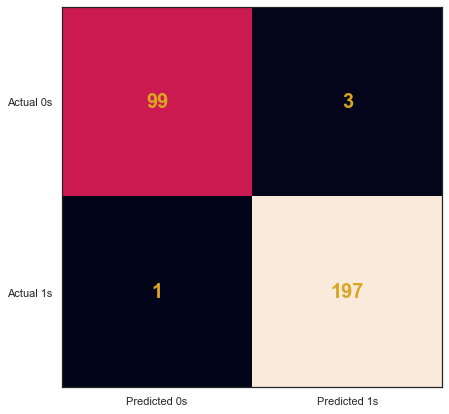

In [179]:
cm = confusion_matrix(y_test, model.predict(x_test))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='goldenrod', fontsize = 20, weight='bold')
plt.show()

In [180]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98       102
        True       0.98      0.99      0.99       198

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



In [181]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3), '- prediction is correct in 98.5% of cases.')
print("Recall:", round(recall_score(y_test, y_pred), 3), '- the model can identify the true banknotes in 99.5% of cases.')

Accuracy: 0.987
Precision: 0.985 - prediction is correct in 98.5% of cases.
Recall: 0.995 - the model can identify the true banknotes in 99.5% of cases.


# 7. Application du modèle

## 7.1. Téléchargement des données et application du modèle

In [182]:
# upload the data for prediction
billets_production = pd.read_csv('billets_production.csv')

In [183]:
billets_production.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [184]:
billets_production.shape

(5, 7)

In [185]:
billets_prod_set_index = billets_production.set_index('id')

In [186]:
billets_prod_set_index.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42
A_2,171.87,104.17,104.13,6.00,3.31,112.09
A_3,172.00,104.58,104.29,4.99,3.39,111.57
A_4,172.49,104.55,104.34,4.44,3.03,113.20
A_5,171.65,103.63,103.56,3.77,3.16,113.33


In [187]:
# running the model using the production data
y_production = model.predict(billets_prod_set_index)

In [188]:
print(y_production)

[False False False  True  True]


In [189]:
y_production.tolist() 

[False, False, False, True, True]

In [190]:
predicted_results = pd.DataFrame(y_production, columns = ['is_genuine'])
predicted_results['id'] = billets_production['id']
predicted_results.head(len(predicted_results))

,is_genuine,id
0,False,A_1
1,False,A_2
2,False,A_3
3,True,A_4
4,True,A_5


## 7.2. Pickling

In [191]:
import pickle

In [192]:
pickle.dump(model, open("model_banknotes.pkl", "wb"))

In [193]:
with open('model_banknotes.pkl', 'rb') as pickle_in: 
     unpickled_object = pickle.load(pickle_in)

print(unpickled_object) 

LogisticRegression(C=1, multi_class='ovr', random_state=0, solver='liblinear')


In [194]:
unpicled_prediction = unpickled_object.predict(billets_prod_set_index)

In [195]:
unpicled_prediction

array([False, False, False,  True,  True])

# Recommendations

* Le modèle de prédiction basé sur la régression logistique montre une sensibilité plus élevée que la prédiction basée sur le clustering k_means, cependant les deux méthodes appliquées montrent une sensibilité assez élevée selon les données utilisées pour l'entraînement :

In [196]:
print('The sensitivity (recall) of K-means clustering is:', sensitivity)

The sensitivity (recall) of K-means clustering is: 0.986


In [197]:
print('The sensitivity (recall) of logistic regression model is:', round(recall_score(y_test, y_pred), 3))

The sensitivity (recall) of logistic regression model is: 0.995


* Cependant, les prédictions obtenues sur la base de deux méthodes sont assez différentes (ne coïncident pas dans plus de 50 % des cas) :

In [198]:
predict_banknote(banknotes_to_test, centroids)

1 : true banknote
1 : true banknote
0 : false banknote
0 : false banknote
1 : true banknote


In [199]:
predicted_results.head(len(predicted_results))

,is_genuine,id
0,False,A_1
1,False,A_2
2,False,A_3
3,True,A_4
4,True,A_5


* Les performances des deux modèles pourraient être plus faibles sur les nouvelles données. Selon l'analyse effectuée, le modèle de régression logistique est recommandé, car il est plus sensible aux données.

# Sources

**Agrawal, Ashutosh** (2014). Understanding Python pickling and how to use it securely. *Synopsis*, https://www.synopsys.com/blogs/software-security/python-pickling/#:~:text=Pickle%20in%20Python%20is%20primarily,transport%20data%20over%20the%20network. (accessed: June 30, 2022) <br>
**Chouinard, Jean-Christophe** (2022). PCA: Principal Component Analysis using Python. https://www.jcchouinard.com/pca-with-python/ (accessed: June 20, 2022) <br>
**Fricker, Tom** (no year). Sensitivity, Specificity and Predictive Values – What is the best way to measure the performance of binary classification models? *Select. Statistical Services*, https://select-statistics.co.uk/blog/sensitivity-specificity-and-predictive-values-what-is-the-best-way-to-measure-the-performance-of-binary-classification-models/ (accessed: June 28, 2022)<br>
**Jakobowicz, Emmanuel** (2021). Faire une régression logistique avec python. *Stat4decision*, https://www.stat4decision.com/fr/faire-une-regression-logistique-avec-python/ (accessed: June21, 2022)   <br>
**Kumar, Ajitesh** (2020). PCA Explained Variance Concepts with Python Example. *Data Analytics: Data, Data Science, Machine Learning, AI*, https://vitalflux.com/pca-explained-variance-concept-python-example/#:~:text=explained_variance_ratio_%20method%20of%20PCA%20is,scaled%20before%20applying%20PCA%20technique (accessed: June 17, 2022) <br>
**Kumar, Ajitesh** (2022). Mean Squared Error or R-Squared – Which one to use? *Data Analytics*, https://vitalflux.com/mean-square-error-r-squared-which-one-to-use/ (accessed: June 29, 2022)<br>
**Mastromatteo, Davide** (2020). The Python pickle Module: How to Persist Objects in Python. *Real Python*, https://realpython.com/python-pickle-module/ (accessed: June 30, 2022)
**McCullum, Nick** (2020). How to Build and Train K-Nearest Neighbors and K-Means Clustering ML Models in Python. *freeCodeCamp*, https://www.freecodecamp.org/news/how-to-build-and-train-k-nearest-neighbors-ml-models-in-python/ (accessed: June 23, 2022)   <br>
**Navlani, Avinash** (2019). Understanding Logistic Regression in Python. Tutorial. *DataCamp*, https://www.datacamp.com/tutorial/understanding-logistic-regression-python (accessed: June 28, 2022) <br>
**Net-informations** (no year). Metrics To Evaluate Machine Learning Algorithms. *Net-informations.com*, http://net-informations.com/ds/psa/rmse.htm (accessed: June 30, 2022) <br>
**Oronigbagbe, Oyindamola** (2021). How to Replace Missing Dataframe Values with a Machine Learning Algorithm. *Python in Plain English*, https://python.plainenglish.io/predict-missing-dataframe-values-with-an-ml-algorithm-717cd872f1a8 (accessed: June 21, 2022)   <br>
**Ostwal, Prasad** (2019). Principal Component Analysis Visualization. https://ostwalprasad.github.io/machine-learning/PCA-using-python.html (accessed: June 20, 2022)  <br>
**Python for Data Science** (no year). Linear Regression. *Python for Data Science*, https://pythonfordatascienceorg.wordpress.com/linear-regression-python/#:~:text=Assumption%20of%20Homoscedasticity&text=This%20can%20be%20tested%20using%20a%20residual%20vs.,test%2C%20or%20White%20general%20test. (accessed: June 29, 2022)<br>
**Rekha, M.** (2020). MLmuse: Correlation and Collinearity — How they can make or break a model. https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a (accessed: June 15, 2022) <br>
**Saslow, Elliot** (2018). Collinearity - What it means, Why its bad, and How does it affect other models? https://medium.com/future-vision/collinearity-what-it-means-why-its-bad-and-how-does-it-affect-other-models-94e1db984168 (accessed: June 18, 2022)  <br>
**Statistics Solutions** (2013). Homoscedasticity. *Statistics Solutions*, https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/homoscedasticity/ (accessed: June 15, 2022)  <br>
**Stojiljković, Mirko** (2020). Logistic Regression in Python. *Real Python*, https://realpython.com/logistic-regression-python/ (accessed: June 27, 2022) <br>